# Temperature Prediction on the Jena Weather Dataset

## Applied Machine Learning (ICS-5110) Coursework


In this Jupyter Notebook, we will implement an **LSTM** algorithm from first principles and use it to predict the temperature on the [Jena Weather Dataset](https://www.kaggle.com/datasets/mnassrib/jena-climate).  

The setup and preprocessing steps are kept exactly the same as with naive bayes and random forest classifier to ensure the fairness of the experiments.

# Setup

## Global variables 

In this section we define global setup variables that will be used through the course of this notebook.

* **KAGGLE_USER** is a string that represents the user's Kaggle username, which is used to access the Kaggle API. This value can be taken from your `kaggle.json` authentication file.
* **KAGGLE_KEY** is a string that represents the user's Kaggle API key, which is used to access the Kaggle API. This value can be taken from your `kaggle.json` authentication file.
* **DROP_SET_THRESHOLD** is a number that represents the threshold for dropping a set of data from further analysis after feature selection.
* **PCA_THRESHOLD** is a number that represents the threshold for selecting the number of PCA components while iterating over the cumulative explained variance.
* **N_FOLDS** is a number that represents the number of folds to use in cross-validation, a technique used to evaluate the performance of a machine learning model.

To download your `kaggle.json` file from [Kaggle](http://kaggle.com/) and access the Kaggle API, follow these steps:

* Go to the Kaggle website and log in to your account.

* Click on your avatar in the top right corner of the page and select the "Account" option.

* Scroll down to the API section and click on the "Create New API Token" button. This will download the `kaggle.json` file to your computer.

In [ ]:
#@title Definition

KAGGLE_USER = 'ruanchaves93' #@param {type:"string"}
KAGGLE_KEY = '7bfda777d3fecae222a86d45e14359a5' #@param {type:"string"}
DROP_SET_THRESHOLD = 0.95 #@param {type:"number"}
PCA_THRESHOLD = 0.95 #@param {type:"number"}
N_FOLDS = 10 #@param {type:"number"} 

## Installation

Install code dependencies in quiet mode.

In [ ]:
!pip install kaggle -qqq


## Imports


Import relevant modules.

In [ ]:
import os
import json

import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

import numpy as np
from typing import List, Dict, Tuple, Union, Optional, Any

import torch
import random
from sklearn.model_selection import train_test_split

# Preprocessing

## Preliminary steps

### Load dataset

Load dataset from Kaggle.

In [ ]:
if not os.path.exists("~/.kaggle/kaggle.json"):
  with open("kaggle.json", "w+") as f:
    json.dump({"username": KAGGLE_USER,"key": KAGGLE_KEY}, f)
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/samin/.kaggle’: File exists


In [ ]:
if not os.path.exists("jena-climate.zip"):
  !kaggle datasets download mnassrib/jena-climate

if not os.path.exists("jena_climate_2009_2016.csv"):
  !unzip jena-climate.zip

In [ ]:
dataset = pd.read_csv("jena_climate_2009_2016.csv")
dataset = dataset.reset_index()

In [ ]:
dataset

,index,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


### Drop temperature columns


The columns `"T (degC)"`, `"Tpot (K)"`, and `"Tdew (degC)"` represent the temperature in degrees Celsius, the potential temperature in Kelvin, and the dew point temperature in degrees Celsius, respectively. Since temperature can be represented in different units, these columns represent the same physical quantity (temperature).

Since these columns are redundant and represent the same thing as the `"T (degC)"` column, we must drop them from the dataset to avoid data leakage.

In [ ]:
dataset.drop("Tpot (K)", inplace=True, axis=1)
dataset.drop("Tdew (degC)", inplace=True, axis=1)

### Convert date and time strings

We define a function that converts date and time strings to timestamps, days of the year, and seconds since midnight. This will capture all three time factors that can affect the temperature at a given point: the date, the season, and the time of the day.

In [ ]:
def convert_to_timestamp(date):
  dt_object = datetime.strptime(date, '%d.%m.%Y %H:%M:%S')
  seconds_since_midnight = dt_object.hour * 60 * 60 + dt_object.minute * 60 + dt_object.second
  return dt_object.timestamp(), dt_object.timetuple().tm_yday, seconds_since_midnight

dataset[["timestamp", "year_day", "seconds"]] = list(dataset["Date Time"].apply(convert_to_timestamp))
dataset.drop("Date Time", inplace=True, axis=1)
dataset

,index,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),timestamp,year_day,seconds
0,0,996.52,-8.02,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1.230765e+09,1,600
1,1,996.57,-8.41,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,1.230766e+09,1,1200
2,2,996.53,-8.51,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,1.230766e+09,1,1800
3,3,996.51,-8.31,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,1.230767e+09,1,2400
4,4,996.51,-8.27,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,1.230767e+09,1,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,420546,1000.07,-4.05,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0,1.483223e+09,366,84000
420547,420547,999.93,-3.35,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,1.483223e+09,366,84600
420548,420548,999.82,-3.16,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2,1.483224e+09,366,85200
420549,420549,999.81,-4.23,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8,1.483225e+09,366,85800


### Define data splits


We split the data into two parts, one for training and development and one for testing. 

Then we use a `factory` to create a nested dictionary structure to store the data from the DataFrame, where the training and development data and the testing data are stored in different keys, and the raw data and processed data are stored in different subkeys. 

In [ ]:
from collections import defaultdict

def factory(): return defaultdict(factory)
data = factory()

test = dataset.tail(int(len(dataset) * 0.2))
df = dataset.head(int(len(dataset) * 0.8))

data["test"]["raw"]["y"]["ndarray"] = test["T (degC)"].to_numpy()
data["test"]["raw"]["y"]["columns"] = list(test[["T (degC)"]].columns)

data["train+dev"]["raw"]["y"]["ndarray"] = df["T (degC)"].to_numpy()
data["train+dev"]["raw"]["y"]["columns"] = list(df[["T (degC)"]].columns)

df.drop("T (degC)", inplace=True, axis=1)
test.drop("T (degC)", inplace=True, axis=1)

df_X = df.to_numpy()
data["test"]["raw"]["x"]["ndarray"] = test.to_numpy()
data["test"]["raw"]["x"]["columns"] = list(test.columns)

data["train+dev"]["raw"]["x"]["ndarray"] = df.to_numpy()
data["train+dev"]["raw"]["x"]["columns"] = list(df.columns)

/home/samin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Visualize the splits


Here we define `visualize_data` that takes a dictionary as input and prints a representation of it in JSON format. The representation replaces the values of each key with the length of the value if it is not a string, and recursively processes nested dictionaries. The resulting dictionary is printed in JSON format.

In [ ]:
import yaml
import copy
import collections.abc
import json
import copy

def visualize_data(data: dict) -> str:
  """
  Visualizes the input data by returning a JSON representation of the data,
  where all non-string values are replaced by their lengths (if possible).
  """
  def get_repr(data: dict) -> dict:
    """
    Returns a copy of the input data where all non-string values are replaced
    by their lengths (if possible).
    """
    for key, value in data.items():
      if isinstance(value, dict):
        # Recursively apply the function to nested dictionaries.
        data[key] = get_repr(value)
      elif not isinstance(value, str):
        try:
          # Replace the value with its length if possible.
          data[key] = len(value)
        except TypeError:
          # Do nothing if the value is not a sequence (i.e., it doesn't have a length).
          pass
    return data
  # Return a JSON representation of the data.
  return json.dumps(get_repr(copy.deepcopy(data)), indent=4)


print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 15
            }
        }
    },
    "train+dev": {
        "raw": {
            "y": {
                "ndarray": 336440,
                "columns": 1
            },
            "x": {
                "ndarray": 336440,
                "columns": 15
            }
        }
    }
}


## Feature Selection



Feature selection is a technique used to identify and select only the most relevant features from a dataset. This is useful because it reduces the dimensionality of the input data, which can improve the performance of machine learning models. Here we will perform feature selection using the filter method and the Pearson correlation coefficient. 

Our implementation of the Pearson correlation coefficient can be described by the formula:

$$ \rho = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \sum_{i=1}^{n}(y_i - \bar{y})^2}} $$

Where $x$ and $y$ are the input arrays and $\bar{x}$ and $\bar{y}$ are the means of the input arrays.

By calculating the Pearson correlation coefficient between all pairs of features, we can identify those that are highly correlated and might not provide any additional useful information for our model. These highly correlated features can then be removed, reducing the dimensionality of the input data and improving the performance of the model.

In [ ]:
def pearson_correlation(a: np.ndarray, b: np.ndarray) -> float:
    # Normalize the input arrays.
    norm_a = a - a.mean()
    norm_b = b - b.mean()
    # Compute the squared norms of the input arrays.
    squared_norm_a = norm_a ** 2
    squared_norm_b = norm_b ** 2
    # Compute the dot product of the normalized input arrays.
    dot_product_a_b = norm_a * norm_b
    # Compute the Pearson correlation coefficient.
    p_value = dot_product_a_b.sum() / np.sqrt(squared_norm_a.sum() * squared_norm_b.sum())
    return p_value

def get_corr_matrix(x: np.ndarray) -> np.ndarray:
  # Initialize the correlation matrix with zeros.
  corr_matrix = np.zeros((x.shape[1], x.shape[1]))
  # Get the upper triangle indices of the correlation matrix.
  i_indices, j_indices = np.triu_indices(x.shape[1])
  # Transpose the input data. Each column will become a row.
  x_t = x.T
  for k in range(len(i_indices)):
    i = i_indices[k]
    j = j_indices[k]
    if i == j:
      # Skip the diagonal.
      continue
    # Get the ith and jth columns of the transposed input data.
    a = x_t[i]
    b = x_t[j]
    # Compute the Pearson correlation coefficient for the ith and jth columns.
    corr_matrix[i][j] = pearson_correlation(a,b)
  return corr_matrix

def get_drop_set(labels: List[str], corr_matrix: np.ndarray, threshold: float = 0.95) -> Tuple[List[str], List[int]]:
  # Compute the absolute value of the correlation matrix.
  abs_corr_matrix = np.absolute(corr_matrix)
  # Zip the indices and values of the columns with a correlation coefficient greater than the threshold.
  drop_set = [(index, item) for index, item in enumerate(labels) if any(abs_corr_matrix[index] > threshold) ]
  # Unzip the list of tuples into two lists: the labels and the indices.
  drop_set_indices, drop_set_values = list(zip(*drop_set))
  return drop_set_values, drop_set_indices

In [ ]:
# Iterating over each dataset for train and test and
# dropping the columns not needed


raw_columns = data["train+dev"]["raw"]["x"]["columns"]
raw_data = data["train+dev"]["raw"]["x"]["ndarray"]

corr_matrix = get_corr_matrix(raw_data)
drop_set_values, drop_set_indices = get_drop_set(raw_columns, corr_matrix, threshold=DROP_SET_THRESHOLD)
print(f"Dropped columns for train+dev : {drop_set_values}")

n_cols = data["train+dev"]["raw"]["x"]["ndarray"].shape[1]
mask = np.ones(n_cols).astype(bool)
mask[list(drop_set_indices)] = False

for dataset in ["train+dev", "test"]:
    data[dataset]["fs"]["x"]["ndarray"] = data[dataset]["raw"]["x"]["ndarray"][:, mask]
    data[dataset]["fs"]["x"]["columns"] = [x for x in raw_columns if x not in drop_set_values]
    data[dataset]["fs"]["y"] = data[dataset]["raw"]["y"]

Dropped columns for train+dev : ('index', 'VPact (mbar)', 'sh (g/kg)', 'wv (m/s)')


In [ ]:
print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 15
            }
        },
        "fs": {
            "x": {
                "ndarray": 84110,
                "columns": 11
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        }
    },
    "train+dev": {
        "raw": {
            "y": {
                "ndarray": 336440,
                "columns": 1
            },
            "x": {
                "ndarray": 336440,
                "columns": 15
            }
        },
        "fs": {
            "x": {
                "ndarray": 336440,
                "columns": 11
            },
            "y": {
                "ndarray": 336440,
                "columns": 1
            }
        }
    }
}


## Rescaling and Normalization

Here we apply rescaling and normalization techniques to our training data. These preprocessing steps are essential for ensuring that the data is properly formatted and ready for principal component analysis (PCA), which we will perform in the next section.

The formulas for min-max scaling and mean normalization are implemented as follows:

$$\text{min max scaling}(arr) = \frac{arr - \text{min}(arr)}{\text{max}(arr) - \text{min}(arr)}$$

$$\text{mean normalisation}(arr) = \frac{arr - \text{mean}(arr)}{\text{max}(arr) - \text{min}(arr)}$$


In [ ]:
def min_max_scaled(arr: np.ndarray) -> np.ndarray:
  """Scales the elements of `arr` by their minimum and maximum values.
  
  This function scales the elements of a n-dimensional array `arr` by 
  the minimum and maximum values along each of its dimensions.
  
  Args:
    arr: The array to be scaled.
  
  Returns:
    A new array with the same shape as `arr`, with its elements scaled
    by their minimum and maximum values.
  """
  return (arr - arr.min(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

def mean_normalisation(arr: np.ndarray) -> np.ndarray:
  """Normalizes the elements of `arr` by their mean value.
  
  This function normalizes the elements of a n-dimensional array `arr` by
  the mean value along each of its dimensions.
  
  Args:
    arr: The array to be normalized.
  
  Returns:
    A new array with the same shape as `arr`, with its elements normalized
    by their mean value.
  """
  return (arr - arr.mean(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

def scale_and_normalize(arr: np.ndarray) -> np.ndarray:
  """Scales and normalizes the elements of `arr` by their minimum and maximum values.
  
  This function first scales the elements of `arr` by their minimum and maximum
  values, and then normalizes the scaled elements by their mean value.
  
  Args:
    arr: The array to be scaled and normalized.
  
  Returns:
    A new array with the same shape as `arr`, with its elements scaled
    and normalized as described above.
  """
  return mean_normalisation(min_max_scaled(arr))

In [ ]:
for dataset in data:
  raw_columns = data[dataset]["raw"]["x"]["columns"]
  raw_data = data[dataset]["raw"]["x"]["ndarray"]

  fs_columns = data[dataset]["fs"]["x"]["columns"]
  fs_data = data[dataset]["fs"]["x"]["ndarray"]
    
    #Data after normalisation

  data[dataset]["raw+norm"]["x"]["ndarray"] = scale_and_normalize(raw_data)
  data[dataset]["raw+norm"]["x"]["columns"] = raw_columns
  data[dataset]["raw+norm"]["y"] = data[dataset]["raw"]["y"]
    #Data after feature selection and normalization

  data[dataset]["fs+norm"]["x"]["ndarray"] = scale_and_normalize(fs_data)
  data[dataset]["fs+norm"]["x"]["columns"] = fs_columns
  data[dataset]["fs+norm"]["y"] = data[dataset]["fs"]["y"]

## PCA ( Principal Component Analysis )

PCA is a dimensionality reduction technique that can be used to reduce the number of features in a dataset while retaining as much of the original information as possible. 

The `PCA` class below takes a dataset as input and computes its covariance matrix, eigenvalues, and eigenvectors. In PCA, the eigenvectors of the covariance matrix are the principal components, and the eigenvalues are the corresponding variances along each principal component.

Our implementation of `PCA` provides two methods: `project`, which projects the dataset onto the principal components, and `determine_components`, which determines the number of principal components required to explain a given threshold of variance in the data. 

Although here we are using PCA to reduce the number of features in our dataset, like other dimensionality reduction algorithms ( e.g. t-SNE ), it can also be used for visualizing high-dimensional data in lower dimensions.

In [ ]:
class PCA(object):
    def __init__(self,X):
      """Perform Principal Component Analysis on a given dataset.

      Args:
        X: 2D numpy array of the dataset.

      Returns:
        None.
      """
      self.X = X
      self.covariance_matrix = np.cov(X, rowvar=False)
      eigenvalues, eigenvectors = np.linalg.eigh(self.covariance_matrix)
      sorted_tuples = sorted(list(zip(eigenvalues, eigenvectors)), key=lambda x: x[0], reverse=True)
      eigenvalues, eigenvectors = list(zip(*sorted_tuples))
      eigenvectors = np.array([np.array(x) for x in eigenvectors]) 
      self.eigenvalues = eigenvalues
      self.eigenvalues_sum = sum(eigenvalues)
      self.eigenvectors = eigenvectors
      self.explained_variance = [ (x / self.eigenvalues_sum) for x in self.eigenvalues]
      self.cumulative_explained_variance = np.cumsum(self.explained_variance)
  
    def project(self, components=2):
      """Projects the dataset onto the given number of principal components.

      Args:
        components: The number of principal components to project the data onto.
          Default is 2.

      Returns:
        The projected dataset.
      """
      projection_matrix = self.eigenvectors[:components, :]
      return self.X.dot(projection_matrix.T)

    def determine_components(self, threshold=0.95):
      """Determines the number of principal components required to explain the given threshold of variance.

      Args:
        threshold: The required threshold of variance that must be explained. Default is 0.95.

      Returns:
        The number of principal components required to explain the given threshold of variance.
      """
      for idx, item in enumerate(self.cumulative_explained_variance):
        if item >= threshold:
          return idx + 1

In [ ]:
norm_datasets = []
for split in data:
  for dataset in data[split]:
    if dataset.endswith("norm"):
      norm_datasets.append((split, dataset))

for split, dataset in norm_datasets:
    norm_data = data[split][dataset]["x"]["ndarray"]
    norm_columns = data[split][dataset]["x"]["columns"]

    pca = PCA(norm_data)
    components = pca.determine_components(threshold=PCA_THRESHOLD)
    print(f"Components for split {split}, dataset {dataset}: {components}")
    X_projection = pca.project(components=components)
    print(components, pca.cumulative_explained_variance)

    new_dataset = dataset + "+" + "pca"
    data[split][new_dataset]["x"]["ndarray"] = X_projection
    data[split][new_dataset]["x"]["columns"] = list(range(X_projection.shape[1]))
    data[split][new_dataset]["y"] = data[split][dataset]["y"]

Components for split test, dataset raw+norm: 6
6 [0.32166702 0.54660085 0.69534578 0.81143348 0.90260895 0.96838896
 0.99359603 0.99843089 0.99926529 0.99997813 0.99999695 0.99999891
 0.99999993 0.99999999 1.        ]
Components for split test, dataset fs+norm: 6
6 [0.2726752  0.47520966 0.63782478 0.77018726 0.89256037 0.96045351
 0.99231487 0.99851002 0.99948189 0.99999972 1.        ]
Components for split train+dev, dataset raw+norm: 6
6 [0.29540117 0.50075803 0.66389256 0.78420554 0.88681922 0.95199141
 0.98218102 0.99429766 0.99827316 0.99926746 0.99999861 0.99999993
 0.99999998 0.99999999 1.        ]
Components for split train+dev, dataset fs+norm: 6
6 [0.2295924  0.44171455 0.63117002 0.76757864 0.9002248  0.95721192
 0.98068465 0.99396184 0.99886513 0.99999969 1.        ]


In [ ]:
print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 15
            }
        },
        "fs": {
            "x": {
                "ndarray": 84110,
                "columns": 11
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "raw+norm": {
            "x": {
                "ndarray": 84110,
                "columns": 15
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "fs+norm": {
            "x": {
                "ndarray": 84110,
                "columns": 11
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "raw+norm+pca": {
            "x": {
                "ndarray": 84110,
         

# Model development

In this section, we will develop and evaluate an LSTM model. The LSTM model has two different number of hidden layers (e.g. one layer and two layers). 

## LSTM

In [ ]:
# initializing the device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# setting the random seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

'''
Taking a list of random numbers with a range from 0 to the total number of train+dev samples. The purpose is to create a random subset of
train+dev dataset since we are unable to train LSTM with the full dataset due to lack of computational resources.
''' 
total_samples = 15000 # number of samples in the train+dev set. Please change this value to create your subset.
dev_samples = 5000 # we are taking 5000 samples for the dev set 
lst = list(range(0,pd.DataFrame(data['train+dev']['raw']['y']['ndarray'], columns=['temp']).shape[0])) # creating a list
random.shuffle(lst) # shuffle the list
lst = lst[:total_samples] # take the number of samples we want in our train+dev subset

In [ ]:
# data preprocessing
'''
This function takes an input feature type and returns the training, dev and test set tensors required for the LSTM model
'''

def prepare_data(feature_type):
    # preparing the train and dev sets
    X = pd.DataFrame(data['train+dev'][feature_type]['x']['ndarray']).iloc[lst] # creating a subset dataframe by using our list with random numbers
    y = pd.DataFrame(data['train+dev']['raw']['y']['ndarray'], columns=['temp']).iloc[lst] # creating a subset dataframe by using our list with random numbers
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=dev_samples, random_state=SEED) # split the dataset into train and dev

    train_x_tensor = torch.tensor(X_train.values, dtype=torch.float32, device=device) # converting the train dataframe into tensor
    dev_x_tensor = torch.tensor(X_dev.values, dtype=torch.float32, device=device) # converting the dev dataframe into tensor
    train_y_tensor = torch.tensor(y_train['temp'].values, dtype=torch.float32, device=device) # converting the train label dataframe into tensor
    dev_y_tensor = torch.tensor(y_dev['temp'].values, dtype=torch.float32, device=device) # converting the dev label dataframe into tensor
    
    # preparing the test set
    test_x_df = pd.DataFrame(data['test'][feature_type]['x']['ndarray']) # we are taking the full test set as it is
    test_x_tensor = torch.tensor(test_x_df.values, dtype=torch.float32, device=device) # converting it into tensor

    test_y_df = pd.DataFrame(data['test']['raw']['y']['ndarray'], columns=['temp']) # doing the same for the labels
    test_y_tensor = torch.tensor(test_y_df['temp'].values, dtype=torch.float32, device=device) # converting it into tensor

    return train_x_tensor, train_y_tensor, dev_x_tensor, dev_y_tensor, test_x_tensor, test_y_tensor


In [ ]:
'''
This class trains an LSTM with one/two hidden layers without using any built-in LSTM function
'''

class LSTM(torch.nn.Module):

    def __init__(self, input_size, hidden_size, batch_size, num_of_features):
        super().__init__()
        self.linear_gi1 = torch.nn.Linear(hidden_size + input_size, hidden_size) # input gate for the first hidden layer
        self.linear_gf1 = torch.nn.Linear(hidden_size + input_size, hidden_size) # forget gate for the first hidden layer
        self.linear_go1 = torch.nn.Linear(hidden_size + input_size, hidden_size) # output gate for the first hidden layer
        self.linear_c1 = torch.nn.Linear(hidden_size + input_size, hidden_size) # cell state for the first hidden layer
        
        self.linear_gi2 = torch.nn.Linear(hidden_size, hidden_size) # input gate for the second hidden layer
        self.linear_gf2 = torch.nn.Linear(hidden_size, hidden_size) # forget gate for the second hidden layer
        self.linear_go2 = torch.nn.Linear(hidden_size, hidden_size) # output gate for the second hidden layer
        self.linear_c2 = torch.nn.Linear(hidden_size, hidden_size) # cell state for the second hidden layer
        self.output_layer = torch.nn.Linear(num_of_features, 1) # output layer provides a single number as output since batch_size = 1

    def forward(self, train_x_tensor, start_point, batch_size, num_of_layers):
        c1 = torch.zeros(1, dtype=torch.float32, device=device) # initializing the cell state
        state = torch.zeros(1, dtype=torch.float32, device=device) # initializing the hidden state
        interim_states = []

        # first LSTM layer
        for t in range(train_x_tensor.shape[1]):
          state_input_cat = torch.cat((state, train_x_tensor[start_point:start_point + batch_size, t]), dim=0) # concatenate the input with the hidden state
          gi1 = torch.sigmoid(self.linear_gi1(state_input_cat))
          gf1 = torch.sigmoid(self.linear_gf1(state_input_cat))
          go1 = torch.sigmoid(self.linear_go1(state_input_cat))
          c1 = gi1*torch.tanh(self.linear_c1(state_input_cat)) + gf1*c1 # performing the LSTM operation to get updated cell state
          state = go1*torch.tanh(c1) # performing the LSTM operation to get updated hidden state
          interim_states.append(state)
        interim_states1 = torch.stack(interim_states, dim=1) # interim states stacked together and will be used as input for the second layer
        
        if num_of_layers == 1: # if the number of layers is 1, then, pass the interim states from the first LSTM layer to the linear output layer
          return self.output_layer(interim_states1)

        # second LSTM layer
        c2 = torch.tensor([0], dtype=torch.float32, device=device)
        state = torch.tensor([0], dtype=torch.float32, device=device)
        interim_states = []
        for t in range(train_x_tensor.shape[1]):
          gi2 = torch.sigmoid(self.linear_gi2(interim_states1[:, t])) # interim state from the first layer is passed as an input
          gf2 = torch.sigmoid(self.linear_gf2(interim_states1[:, t]))
          go2 = torch.sigmoid(self.linear_go2(interim_states1[:, t]))
          c2 = gi2*torch.tanh(self.linear_c2(interim_states1[:, t])) + gf2*c2 # performing the LSTM operation to get updated cell state
          state = go2*torch.tanh(c2) # performing the LSTM operation to get updated hidden state
          interim_states.append(state)
        interim_states2 = torch.stack(interim_states, dim=1)
            
        return self.output_layer(interim_states2) # pass the interim states from the second LSTM layer to the linear output layer

In [ ]:
'''
This class utilizes the LSTMCell built-in function provided by PyTorch.
''' 

class LSTM_PYTORCH(torch.nn.Module):

    def __init__(self, input_size, hidden_size, batch_size, num_of_features):
        super().__init__()
        self.rnn1_cell = torch.nn.LSTMCell(hidden_size + input_size, hidden_size) # lstm cell for the first layer
        self.rnn2_cell = torch.nn.LSTMCell(hidden_size, hidden_size) # lstm cell for the second layer
        self.output_layer = torch.nn.Linear(num_of_features, 1) 

    def forward(self, input_x_tensor, start_point, batch_size, num_of_layers):
        c = torch.tensor([0], dtype=torch.float32, device=device) # initializing the cell state for the first layer
        state = torch.tensor([0], dtype=torch.float32, device=device) # initializing the hidden state for the first layer
        interm_states = []
    
        for t in range(input_x_tensor.shape[1]):
          (state, c) = self.rnn1_cell(torch.cat((state, input_x_tensor[start_point:start_point + batch_size, t]), dim=0), (state, c)) 
          interm_states.append(state)
        interm_states1 = torch.stack(interm_states, dim=1)
        if num_of_layers == 1:
          return self.output_layer(interm_states1)

        c = torch.tensor([0], dtype=torch.float32, device=device) # initializing the cell state for the second layer
        state = torch.tensor([0], dtype=torch.float32, device=device) # initializing the cell state for the second layer
        interm_states = []
        for t in range(input_x_tensor.shape[1]):
          (state, c) = self.rnn2_cell(interm_states1[:, t], (state, c))
          interm_states.append(state)
        interm_states2 = torch.stack(interm_states, dim=1)

        return self.output_layer(interm_states2)

In [ ]:
# training an LSTM

feature_type = 'fs+norm' # setting the input feature type
train_x_tensor, train_y_tensor, dev_x_tensor, dev_y_tensor, test_x_tensor, test_y_tensor = prepare_data(feature_type) # prepare the dataset

# setting some hyper-parameters
input_size = 1 # each time step, we are taking one number
hidden_size = 1 # hidden state size
batch_size = 1 # set the batch size
num_of_features = pd.DataFrame(data['train+dev'][feature_type]['x']['ndarray']).shape[1]
num_of_layers = 1 # number of LSTM layers


lstm = LSTM(input_size, hidden_size, batch_size, num_of_features) # getting an instance of the model
lstm.to(device)

optimiser = torch.optim.Adam(lstm.parameters(), lr=1e-4) # using adam optimizer with a learning rate of 1e-4
criterion = torch.nn.MSELoss() # setting the criterion

print('epoch', 'train_MSE', 'dev_MSE')
epochs = 40 # setting the number of epochs
plot_train = []
plot_dev = []
iterations_train = int(train_x_tensor.shape[0]/batch_size)
iterations_dev = int(dev_x_tensor.shape[0]/batch_size)

for epoch in range(epochs):
  start_point = 0 # starting from the first training sample
  errors_train = []
  for step in range(0, iterations_train):
      optimiser.zero_grad() # we are not accumulating gradient
      output = lstm(train_x_tensor, start_point, batch_size, num_of_layers) # passing a training sample forward and getting the output
      error = criterion(output, train_y_tensor[start_point:start_point + batch_size].unsqueeze(1)) # calculating the MSE error
      start_point = start_point + batch_size # updating the starting point
      error.backward() # back-propagate the error
      optimiser.step() # update the gradients
      errors_train.append(error.detach().tolist()) # keeping a list of training errors for plotting MSE per epoch

  errors_dev = []
  start_point = 0 # staring from the first dev sample
 
  for step in range(0, iterations_dev):
      with torch.no_grad():
          output = lstm(dev_x_tensor, start_point, batch_size, num_of_layers) # passing a dev sample forward and getting the output
          error = criterion(output, dev_y_tensor[start_point:start_point + batch_size].unsqueeze(1)) # calculating the MSE error
          start_point = start_point + batch_size # updating the starting point
          errors_dev.append(error.detach().tolist()) # keeping a list of dev errors for plotting MSE per epoch

  if True:
          plot_train.append(sum(errors_train)/len(errors_train)) # for each epoch, keeping the train error
          plot_dev.append(sum(errors_dev)/len(errors_dev)) # for each epoch, keeping the dev error
          print(epoch + 1, sum(errors_train)/len(errors_train), sum(errors_dev)/len(errors_dev))
print()

epoch train_MSE dev_MSE
1 93.36243281027328 75.33628529509822
2 70.81152356672713 70.8822541094963
3 70.24874104009801 70.44965860389632
4 69.60289863300281 69.99231545754463
5 68.58878794057068 69.16267969893237
6 66.9620398870202 67.63962667294916
7 64.40494151581312 64.97707413952085
8 60.52791325386936 60.63880180715217
9 54.941464337818346 54.19214153469519
10 47.53670332005673 45.774165760080535
11 38.84084449931597 36.3628534320374
12 29.844050533738024 27.24959220320703
13 21.532408307923067 19.56475236770946
14 14.725562555486325 14.089140084268886
15 9.931308273760923 11.019250092887276
16 7.107514087078259 9.78550383576156
17 5.641653963534115 9.43235734727385
18 4.832921803081104 9.349176832435015
19 4.297375895021905 9.353154631379859
20 3.9008885037752328 9.408354777264929
21 3.5951654310895997 9.493053549296434
22 3.352799856707035 9.589185706188044
23 3.155451862888206 9.685988974424413
24 2.9909792916903397 9.777950605310847
25 2.851224848992873 9.862901313921908
26 2.

In [ ]:
# saving the model

PATH = "content/state_dict_model.pt"
torch.save(lstm, PATH)

In [ ]:
# loading the model

model = torch.load(PATH)
model.eval()

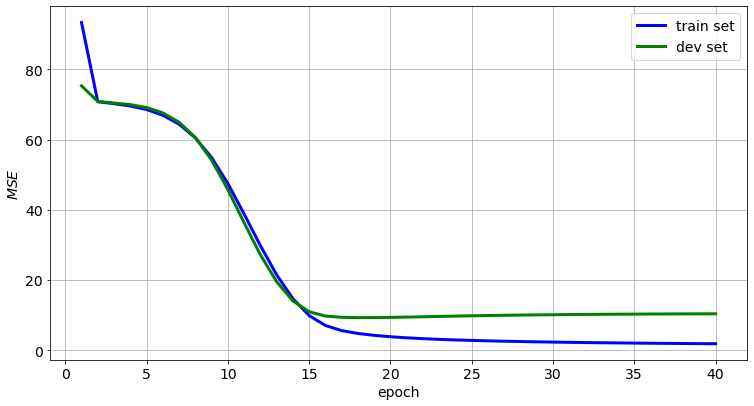

In [ ]:
# plotting the graph

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('$MSE$')
ax.plot(range(1, 40 + 1), plot_train, color='blue', linestyle='-', linewidth=3, label='train set')
ax.plot(range(1, 40 + 1), plot_dev, color='green', linestyle='-', linewidth=3, label='dev set')
ax.grid()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 6.5)
matplotlib.rc('font', size=14)
plt.legend()
plt.savefig('mse-epoch.png')

In [ ]:
# calculate MSE on the test set

with torch.no_grad():
    start_point = 0
    errors = []
    batch_size = 1
    for i in range(0, test_x_tensor.shape[0]):
      output = lstm(test_x_tensor, start_point, batch_size, num_of_layers)
      error = criterion(output, test_y_tensor[start_point:start_point + batch_size].unsqueeze(1))
      start_point = start_point + batch_size
      errors.append(error.detach().tolist())
    print(sum(errors)/len(errors))

9.737213240979774


# Conclusions


Here, we get an MSE of 9.73 for an LSTM model with a single hidden layer and fs+norm input features. The detailed results of all of our experiments can be found in our report.